In [1]:
!date

Thu Feb  8 07:45:57 EST 2024


In [2]:
pwd

'/mmfs1/data/aglinska/BC-sim/Code'

In [3]:
import os 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
from scipy.spatial.distance import pdist,squareform
from rsa_funcs import fit_rsa,make_RDM,get_triu
from tqdm import tqdm

In [133]:
analyses = [a for a in os.listdir('../scratch/') if not a.startswith('.')]
analyses = np.array(analyses)
created_date = np.array([os.stat((os.path.join('../scratch/',analysis))).st_mtime for analysis in analyses])
created_date = np.argsort(created_date)[::-1]
#analyses.sort()
analyses = analyses[created_date]

def check_done(analysis_name):
    if os.path.exists(os.path.join('../scratch/',analysis_name,'stage_1')):
        n1 = len([f for f in os.listdir(os.path.join('../scratch/',analysis_name,'stage_1')) if f.startswith('varexp_attmp')])
    else:
        n1 = 0
    
    if os.path.exists(os.path.join('../scratch/',analysis_name,'stage_2')):
        n2 = len([f for f in os.listdir(os.path.join('../scratch/',analysis_name,'stage_2')) if f.startswith('varexp_attmp')])
    else:
        n2 = 0
    
    if os.path.exists(os.path.join('../scratch/',analysis_name,'stage_3')):
        n3 = len([f for f in os.listdir(os.path.join('../scratch/',analysis_name,'stage_3')) if f.startswith('varexp_attmp')])
    else:
        n3 = 0
    
    print(f'{analysis_name} {n1} {n2} {n3}')

[check_done(analysis_name) for analysis_name in analyses];


CVAE-5type-new2-N1000-YgKpqHLsbP 46 2 0
CVAE-5type-new2-N1000-QMdgkERhZu 49 3 0
CVAE-5type-new2-N1000-HigqUEMwsv 48 20 0
CVAE-5type-new2-N1000-nruquYmakm 46 20 0
CVAE-5type-new2-N1000-VOLeHEZiKM 45 20 0
CVAE-5type-new8-N1000-WNSmHdJfHp 47 20 0
CVAE-5type-new8-N1000-OBeOSwOKAx 0 0 0
CVAE-5type-new8-N1000-jrztwaTlcz 0 0 0
CVAE-5type-new8-N1000-oLcrhaGxfz 0 0 0
CVAE-5type-new8-N1000-nDacvOYHUM 0 0 0
CVAE-5type-new8-N1000-lxZdNNaOmT 0 0 0
CVAE-5type-new8-N1000-JQZZGGEDIe 44 1 0
CVAE-5type-new8-N1000-BuRaiOFEKc 44 20 0
CVAE-5type-new8-N1000-QVofYHFBwC 44 20 0
CVAE-5type-new8-kEbhwNpjgG 43 20 0
CVAE-5type-new8-sKddDMKpyI 43 20 0
CVAE-5type-new8-FGuTWrFkZi 46 20 0
CVAE-5type-new8-XsGkLzfAsQ 46 20 0
CVAE-5type-new8-N1000-yLeguXNthA 47 20 0
CVAE-5type-new8-N1000-CKSrNZbPPj 45 20 0
CVAE-5type-8D-old-N500-MrwoSoQWHR 44 20 0
CVAE-5type-new8-zzzygCizHs 47 20 0
CVAE-5type-new-npHGGDKsAY 48 20 0
CVAE-5type-new-zQzspLVHLH 49 20 0
CVAE-5type-new-SEOUWNcwrP 49 20 0
CVAE-5type-new-buzzKzmTxr 45 20 0
VAE_

In [5]:
#data_csv_fn = '../Data/synth-data-02.csv'
data_csv_fn = '../Data/synth-data-02-N1000.csv'
#data_csv_fn = '../Data/synth-data-02.csv'
#data_csv_fn = '../Data/synth-data-01-N500.csv'

df = pd.read_csv(data_csv_fn)
n = df.shape[0]
patient_idx = np.nonzero(df['dx'].values==1)[0]
control_idx = np.nonzero(df['dx'].values==0)[0]
subtype = df['subtype'].values[patient_idx]

rdm_tx_s = make_RDM(df.iloc[df['dx'].values==1]['adhd_tx'].values,data_scale='ratio', metric='euclidean')
rdm_tx_z = make_RDM(df.iloc[df['dx'].values==1]['td_tx'].values,data_scale='ratio', metric='euclidean')
triu = np.triu_indices(rdm_tx_s.shape[0],1)
vec_tx_s = rdm_tx_s[triu]
vec_tx_z = rdm_tx_z[triu]

In [6]:
def get_descriptive(vec):
    vec = np.array(vec)
    #print(f'M = {vec.mean():.2f}, SD = {vec.std():.2f}, range {vec.min():.2f}-{vec.max():.2f}')
    print(f'M = {np.nanmean(vec):.2f}, SD = {np.nanstd(vec):.2f}, range {np.nanmin(vec):.2f}-{np.nanmax(vec):.2f}')

In [7]:
def pretty_t_1sample(vec,popmean):
    from scipy.stats import ttest_1samp
    t,p = ttest_1samp(vec,popmean,alternative='two-sided')
    if p < .001:
        print(f't({len(vec)-1}) = {t:.2f}, p < .001')
    else:
        print(f't({len(vec)-1}) = {t:.2f}, p = {p:.3f}')

In [8]:
def pretty_t_ind(vec1,vec2):
    from scipy.stats import ttest_ind
    t,p = ttest_ind(vec1,vec2)
    
    if p < .001:
        print(f't({len(vec1)+len(vec2)-2}) = {t:.2f}, p < .001')
    else:
        print(f't({len(vec1)+len(vec2)-2}) = {t:.2f}, p = {p:.3f}')

In [9]:
def plot_scatters(s_latents,data_csv_fn):
    #data_csv_fn = '../synth-data-05/data_description.csv'
    df5 = pd.read_csv(data_csv_fn)
    patient_idx_5 = np.nonzero(df5['dx'].values==1)[0]
    subtype_5 = df5['subtype'].values[patient_idx_5]
    n_subtypes = len(np.unique(subtype_5))
    # print(df5.shape)
    # print(subtype_5.shape)
    # print(s_latents.shape)
    # print(subtype_5)
    
    pc_comps = [PCA(n_components=2).fit_transform(s_latents[i,:,-1,:,:].swapaxes(0,1).reshape(s_latents.shape[3],-1) ) for i in range(s_latents.shape[0])]

    #print(pc_comps[0].shape)
    colors = [[243,101,37],[253,154,61],[255,205,101],[103,127,143],[167,167,167]]
    
    plt.figure(figsize=(int(s_latents.shape[0]*4),5))
    for r in range(s_latents.shape[0]):
        plt.subplot(1,s_latents.shape[0],r+1)
        for i in range(n_subtypes):
            plt.scatter(pc_comps[r][subtype_5==i+1,0],pc_comps[r][subtype_5==i+1,1],color=np.array(colors[i])/255)
        plt.title(f'repetition {r+1}')
        plt.legend(np.unique(subtype_5))


def plot_scatter(s_latents,data_csv_fn):
    #data_csv_fn = '../synth-data-05/data_description.csv'
    df5 = pd.read_csv(data_csv_fn)
    patient_idx_5 = np.nonzero(df5['dx'].values==1)[0]
    subtype_5 = df5['subtype'].values[patient_idx_5]
    n_subtypes = len(np.unique(subtype_5))
    # print(df5.shape)
    # print(subtype_5.shape)
    # print(s_latents.shape)
    # print(subtype_5)
    
    #pc_comps = [PCA(n_components=2).fit_transform(s_latents[i,:,-1,:,:].swapaxes(0,1).reshape(s_latents.shape[3],-1) ) for i in range(s_latents.shape[0])]
    pc_comps = PCA(n_components=2).fit_transform(s_latents[0,:,-1,:,:].swapaxes(0,1).reshape(s_latents.shape[3],-1) )

    #print(pc_comps[0].shape)
    colors = [[243,101,37],[253,154,61],[255,205,101],[103,127,143],[167,167,167]]
    colors = [[158,131,221],[40,179,219],[139,201,97],[247,193,83],[237,73,89]]
    
    #plt.figure(figsize=(int(s_latents.shape[0]*4),5))
    plt.figure(figsize=(5,5))
    r = 0
    #for r in range(s_latents.shape[0]):
    #plt.subplot(1,s_latents.shape[0],r+1)
    for i in range(n_subtypes):
        plt.scatter(pc_comps[subtype_5==i+1,0],pc_comps[subtype_5==i+1,1],color=np.array(colors[i])/255)
    #plt.title(f'repetition {r+1}')
    plt.legend(np.unique(subtype_5))
    plt.xlabel('PC 1 (a.u)')
    plt.ylabel('PC 2 (a.u)')

In [10]:
from numpy import arctanh as fisher_z # https://stats.stackexchange.com/questions/109028/fishers-z-transform-in-python
import numpy as np
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.stats import kendalltau

def fit_rsa(rdm_data,rdm_model,metric='kendalltau'):
    # Takes in two similarity matrices (n x n), has to be square, symmetrical, and either 1s or 0s on the diagonal
    # vectorizes them 
    # Calculates a correlation between them
    # returns r value (between -1 and 1)

    if metric=='kendalltau':
        #print('metric==kendalltau') 
        return kendalltau(get_triu(rdm_data),get_triu(rdm_model))[0]
    elif metric=='pearsonr':
        #print('metric==pearsonr') 
        return np.corrcoef(get_triu(rdm_data),get_triu(rdm_model))[0,1]
    else:
        print('not implemented, wtf')
        return np.nan
        
def make_RDM(inVec,data_scale='ratio',metric='euclidean'):
    # Makes an similarity matrix
    # Takes in a data matrix (n x p), subjects as rows, and abitrary number of features 
    # Whether you give it a 5x2 or a 5x10000 matrix, will give back a 5x5 similarity matrix
    # 
    vec = inVec # Takes whatever data you give it 
    vec = (vec - min(vec.flatten())) / (max(vec.flatten())-min(vec.flatten())) # Normalizes between 0 and 1
    
    if np.ndim(inVec)==1: # must be at least 2D
        vec = np.vstack((vec,np.zeros(vec.shape))).transpose() # this is... just... magic. so beautiful. I mean really. 
        # ^ ok ok lemme explain 
        # pdist function below, works on >=2D data
        # this is a hack in case you want to use it on 1D data
        # in case you pass it a 1D vector, it adds a column of zeros
        # which doesnt change the distances, 
                   
    mat = squareform(pdist(vec,metric=metric).transpose()) # Takes in calcs the distances, turns into a dissimilarity matrix

    if data_scale=='ordinal': # In case the data is ordinal, makes into a same or differnt matrix or ones and zeros
        mat[mat!=0]=1 # Make into zeros and ones
        
    return mat

def get_triu(inMat):
    # Nifty function that takes in a similarity matrix (nxn) and vectorizes it (returns the upper triangle values)
    
    assert np.ndim(inMat)==2, 'not 2 dim, wtf' # Check if some dummy passed a nd array instead of a simmmat
    assert inMat.shape[0]==inMat.shape[1], 'not a square' # make sure it's a square

    n = inMat.shape[0]
    triu_vec = inMat[np.triu_indices(n=n,k=1)] # Takes the upper triangle values
    
    return triu_vec

from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

def get_clustering_acc(mat,subtype,n_components=2):
    c_ = GaussianMixture(n_components=n_components).fit_predict(mat)
    return adjusted_rand_score(c_,subtype)

In [11]:
#analyses = ['VAE_2type_dqgHKSXDPB','VAE_2type_zEETSowiEi','VAE_2type_IAVVVqCzhy','VAE_2type_YsDhiVwbfr','VAE_uHobWzHSMC','VAE_xxVLVwfNvW',]
analyses = ['VAE_uHobWzHSMC','VAE_2type_dqgHKSXDPB','VAE_2type_zEETSowiEi','VAE_2type_IAVVVqCzhy','VAE_2type_YsDhiVwbfr']
#analyses = ['VAE_TZhLdgkcdn','VAE_2type_dqgHKSXDPB','VAE_2type_IAVVVqCzhy','VAE_2type_YsDhiVwbfr','VAE_2type_zEETSowiEi']
analyses = ['VAE_2type_N1000XqPxAUfMDb','VAE_2type_N1000rNGtnKsnGq','VAE_2type_N1000kHBOoowhQG','VAE_2type_N1000uBZSdHlQQc','VAE_2type_N1000PnRPePktJT']

vae_varexps = []
vae_varexps_m = []
latents = []

#analysis = analyses[0]
for analysis in analyses:
    training_logs_fns = [f for f in os.listdir(f'../scratch/{analysis}/stage_2/') if f.startswith('training_log_')]
    training_logs = [np.load(os.path.join(f'../scratch/{analysis}/stage_2/',training_log)) for training_log in training_logs_fns]
    varexp = [training_log['varExps'][-1] for training_log in training_logs]
    varexp = np.array(varexp)
    
    vae_varexps.append( varexp )
    vae_varexps_m.append( varexp.mean() )
    latents.append( [training_log['l_patients'] for training_log in training_logs] )

latents = np.array(latents)
vae_varexps = np.array(vae_varexps)
vae_varexps_m = np.array(vae_varexps)

vae_c_acc_indiv = []
for i in range( latents.shape[0] ):
        vae_c_acc_indiv.append( [get_clustering_acc(latents[i,j,:,:],subtype) for j in range( latents.shape[1] )])
vae_c_acc_indiv = np.array(vae_c_acc_indiv)

vae_features_stacked = np.array([np.hstack([latents[j,i,:,:] for i in range(latents.shape[1])]) for j in range(latents.shape[0])])
vae_c_acc_ens = [get_clustering_acc(vae_features_stacked[i,:,:],subtype) for i in range(vae_features_stacked.shape[0])]

res_vae = {}
res_vae['latents'] = latents
res_vae['latents_stacked'] = vae_features_stacked
res_vae['varexps'] = vae_varexps
res_vae['varexps_m'] = vae_varexps_m
res_vae['c_acc_indiv'] = vae_c_acc_indiv
res_vae['c_acc_ens'] = np.array(vae_c_acc_ens)

[print(f'{key} | {res_vae[key].shape}') for key in list(res_vae.keys())];

latents | (5, 20, 500, 4)
latents_stacked | (5, 500, 80)
varexps | (5, 20)
varexps_m | (5, 20)
c_acc_indiv | (5, 20)
c_acc_ens | (5,)


In [12]:
get_descriptive(res_vae['c_acc_indiv'])

M = 0.16, SD = 0.13, range -0.00-0.59


In [13]:
get_descriptive(res_vae['c_acc_ens'])

M = 0.10, SD = 0.00, range 0.10-0.11


In [14]:
get_descriptive(res_vae['c_acc_ens'])

M = 0.10, SD = 0.00, range 0.10-0.11


In [15]:
pretty_t_1sample(res_vae['c_acc_ens'],.5)

t(4) = -177.63, p < .001


In [16]:
pretty_t_1sample(fisher_z(res_vae['c_acc_ens']),0)

t(4) = 45.33, p < .001


In [17]:
res_vae['c_acc_ens']

array([0.098055  , 0.10579614, 0.09554085, 0.10579614, 0.10579487])

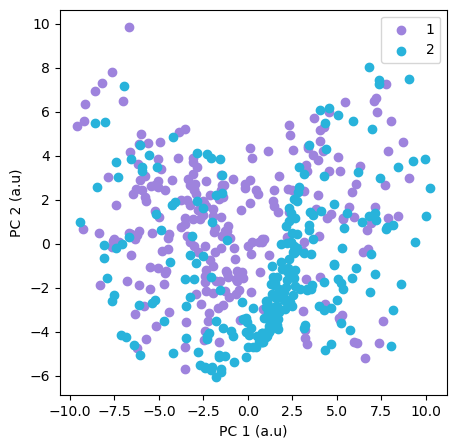

In [18]:
#plot_scatter(res_vae['latents'][:,:,np.newaxis,:,:],data_csv_fn='../Data/synth-data-02.csv')
plot_scatter(res_vae['latents'][:,:,np.newaxis,:,:],data_csv_fn='../Data/synth-data-02-N1000.csv')

In [19]:
pcs = PCA(n_components=2).fit_transform(res_vae['latents_stacked'][0,:,:])
c = GaussianMixture(n_components=2).fit_predict(res_vae['latents_stacked'][0,:,:])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


([], [])

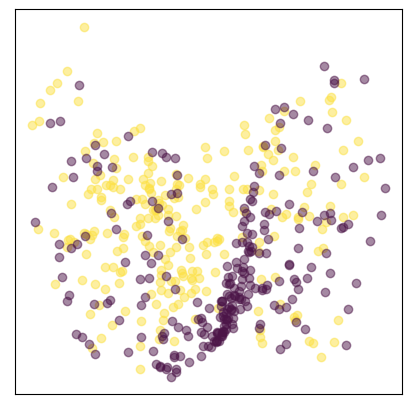

In [20]:
plt.figure(figsize=(5,5))
plt.scatter(pcs[subtype==1,0],pcs[subtype==1,1],c=np.array([252,225,67])/255,alpha=.5)
plt.scatter(pcs[subtype==2,0],pcs[subtype==2,1],c=np.array([76,21,72])/255,alpha=.5)
plt.xticks([])
plt.yticks([])
#plt.xlabel('PC 1 (a.u)')
#plt.ylabel('PC 2 (a.u)')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


([], [])

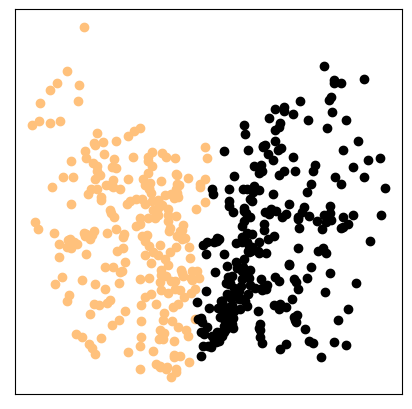

In [21]:
plt.figure(figsize=(5,5))
plt.scatter(pcs[c==0,0],pcs[c==0,1],c=np.array([255,193,124])/255)
plt.scatter(pcs[c==1,0],pcs[c==1,1],c=np.array([0,0,0])/255)
plt.xticks([])
plt.yticks([])

In [22]:
#randVals = np.array([adjusted_rand_score(GaussianMixture(n_components=2).fit_predict(np.random.permutation(res_vae['latents_stacked'][0,:,:].flatten()).reshape(res_vae['latents_stacked'][0,:,:].shape)),subtype) for i in range(100)])

In [23]:
#pretty_t_ind(fisher_z(res_vae['c_acc_ens']),fisher_z(randVals))
#pretty_t_ind(fisher_z(res_vae['c_acc_ens']),fisher_z([adjusted_rand_score(subtype,np.array([np.random.choice([0,1]) for i in range(1000)])) for  j in range(100)]))

In [24]:
#analyses = ['2type-GCyPfzEyNN','2type-odHQZhUYxZ','2type-8DqULkbZtaFi','2type-QzJmjkwddT','2type-ImTsKjutaD','2type-yvdvqaCvSX',]
def get_cvae_res(analyses,data_csv_fn = '../Data/synth-data-02.csv'):
    #data_csv_fn = '../Data/synth-data-02.csv'
    #data_csv_fn = '../Data/synth-data-01-N500.csv'
    
    df = pd.read_csv(data_csv_fn)
    n = df.shape[0]
    patient_idx = np.nonzero(df['dx'].values==1)[0]
    control_idx = np.nonzero(df['dx'].values==0)[0]
    subtype = df['subtype'].values[patient_idx]
    n_subtypes = len(np.unique(subtype))
    print(n_subtypes)
    
    rdm_tx_s = make_RDM(df.iloc[df['dx'].values==1]['adhd_tx'].values,data_scale='ratio', metric='euclidean')
    rdm_tx_z = make_RDM(df.iloc[df['dx'].values==1]['td_tx'].values,data_scale='ratio', metric='euclidean')
    triu = np.triu_indices(rdm_tx_s.shape[0],1)
    vec_tx_s = rdm_tx_s[triu]
    vec_tx_z = rdm_tx_z[triu]
    
    s_latents = []
    z_latents = []
    cvae_varexps = []
    cvae_varexps_m = []
    
    for analysis in analyses:
        training_logs_fns = [f for f in os.listdir(f'../scratch/{analysis}/stage_2/') if f.startswith('training_log_')]
        training_logs = [np.load(os.path.join(f'../scratch/{analysis}/stage_2/',training_log)) for training_log in training_logs_fns]
        varexp = [training_log['varExps'][-1] for training_log in training_logs]
        varexp = np.array(varexp)
        
        cvae_varexps.append( varexp )
        cvae_varexps_m.append( varexp.mean() )
        s_latents.append( [training_log['s_patients'] for training_log in training_logs] )
        z_latents.append( [training_log['z_patients'] for training_log in training_logs] )
    
    
    s_latents = np.array(s_latents)
    cvae_c_acc_indiv = []
    for i in range( s_latents.shape[0] ):
            cvae_c_acc_indiv.append( [get_clustering_acc(s_latents[i,j,-1,:,:],subtype,n_components=n_subtypes) for j in range( s_latents.shape[1] )])
    cvae_c_acc_indiv = np.array(cvae_c_acc_indiv)

    s_latents_stacked = np.array([np.hstack([s_latents[j,i,-1,:] for i in range(s_latents.shape[1])]) for j in range(s_latents.shape[0])])
    c_acc_ens = [get_clustering_acc(s_latents_stacked[i,:,:],subtype,n_components=n_subtypes) for i in range(s_latents_stacked.shape[0])]
    
    res_cvae = {}
    res_cvae['varexps'] = np.array(cvae_varexps)
    res_cvae['varexps_m'] = np.array(cvae_varexps_m)
    res_cvae['s_latents'] = np.array(s_latents)
    res_cvae['z_latents'] = np.array(z_latents)
    res_cvae['c_acc_indiv'] = np.array(cvae_c_acc_indiv)
    #res_cvae['c_acc_ens'] = res_cvae['c_acc_indiv'].mean(axis=1)
    res_cvae['s_latents_stacked'] = s_latents_stacked
    res_cvae['c_acc_ens'] = np.array(c_acc_ens)
    #res_cvae[''] = 
    return res_cvae

## CVAE N=1000

In [25]:
res_cvae_N1000 = res_cvae_N1000 = get_cvae_res( ['2type-N1000-SsAkmZgMEg','2type-N1000-jgaXcHvlrU','2type-N1000-yVufeEzKhJ','2type-N1000-lNlPUEKniS','2type-N1000-RyexWBHBsC',],data_csv_fn = '../Data/synth-data-02-N1000.csv')

2


In [26]:
get_descriptive(res_cvae_N1000['c_acc_indiv'])

get_descriptive(res_cvae_N1000['c_acc_ens'])

pretty_t_1sample(res_cvae_N1000['c_acc_ens'],1/2)

M = 0.59, SD = 0.22, range 0.00-1.00
M = 0.90, SD = 0.03, range 0.87-0.96
t(4) = 24.27, p < .001


In [27]:
print('ΔM={}'.format( (res_cvae_N1000['c_acc_ens'].mean()-res_vae['c_acc_ens'].mean()).round(2) ))
pretty_t_ind(fisher_z(res_cvae_N1000['c_acc_ens']),fisher_z(res_vae['c_acc_ens']))

ΔM=0.8
t(8) = 12.69, p < .001


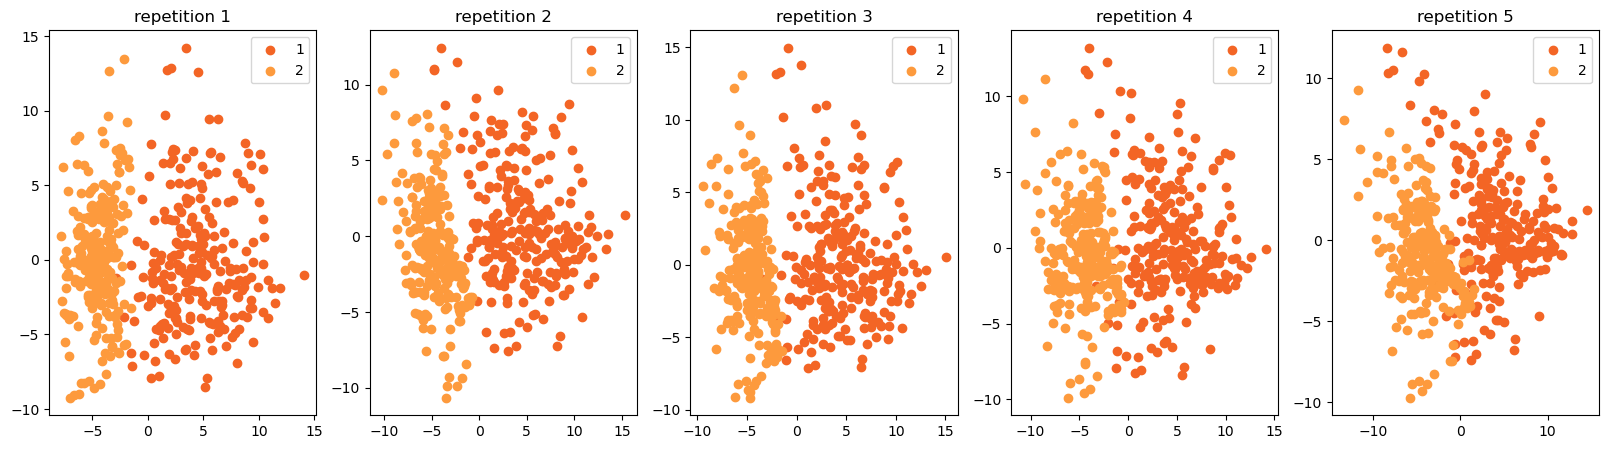

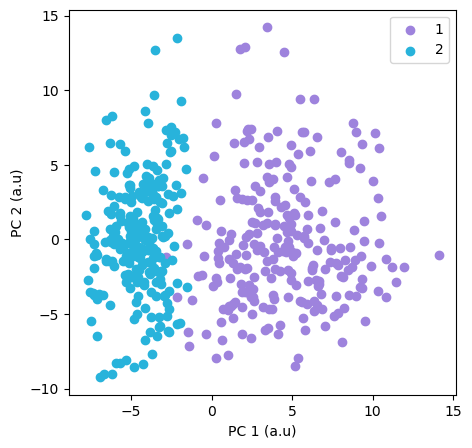

In [28]:
plot_scatters(res_cvae_N1000['s_latents'],data_csv_fn = '../Data/synth-data-02-N1000.csv')
plot_scatter(res_cvae_N1000['s_latents'],data_csv_fn = '../Data/synth-data-02-N1000.csv')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

([], [])

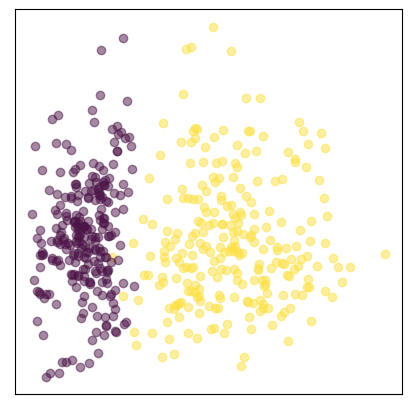

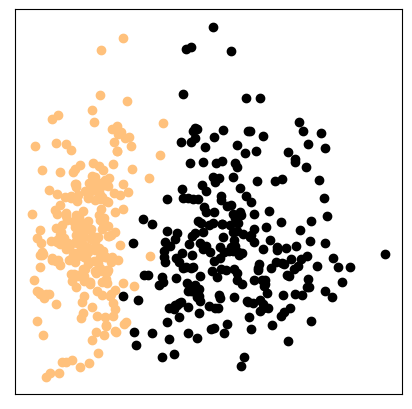

In [29]:
pcs = PCA(n_components=2).fit_transform(res_cvae_N1000['s_latents_stacked'][0,:,:])
c = GaussianMixture(n_components=2).fit_predict(res_cvae_N1000['s_latents_stacked'][0,:,:])

plt.figure(figsize=(5,5))
plt.scatter(pcs[subtype==1,0],pcs[subtype==1,1],c=np.array([252,225,67])/255,alpha=.5)
plt.scatter(pcs[subtype==2,0],pcs[subtype==2,1],c=np.array([76,21,72])/255,alpha=.5)
plt.xticks([])
plt.yticks([])
#plt.xlabel('PC 1 (a.u)')
#plt.ylabel('PC 2 (a.u)')

plt.figure(figsize=(5,5))
plt.scatter(pcs[c==0,0],pcs[c==0,1],c=np.array([255,193,124])/255)
plt.scatter(pcs[c==1,0],pcs[c==1,1],c=np.array([0,0,0])/255)
plt.xticks([])
plt.yticks([])

## CVAE N=2000

In [30]:
res_cvae = get_cvae_res(['2type-ImTsKjutaD','2type-yvdvqaCvSX','2type-GCyPfzEyNN','2type-odHQZhUYxZ','2type-QzJmjkwddT'],data_csv_fn = '../Data/synth-data-02.csv')
res_cvae['s_latents_stacked'].shape

2


/data/aglinska/anaconda3/lib/python3.8/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,


(5, 1000, 40)

In [31]:
get_descriptive(res_cvae['c_acc_indiv'])

M = 0.70, SD = 0.26, range -0.00-1.00


In [32]:
get_descriptive(res_cvae['c_acc_ens'])

M = 0.99, SD = 0.01, range 0.97-1.00


In [33]:
pretty_t_1sample(res_cvae['c_acc_ens'],0.5)

t(4) = 91.04, p < .001


In [34]:
pretty_t_1sample(res_cvae['c_acc_ens'],0.0)

t(4) = 183.26, p < .001


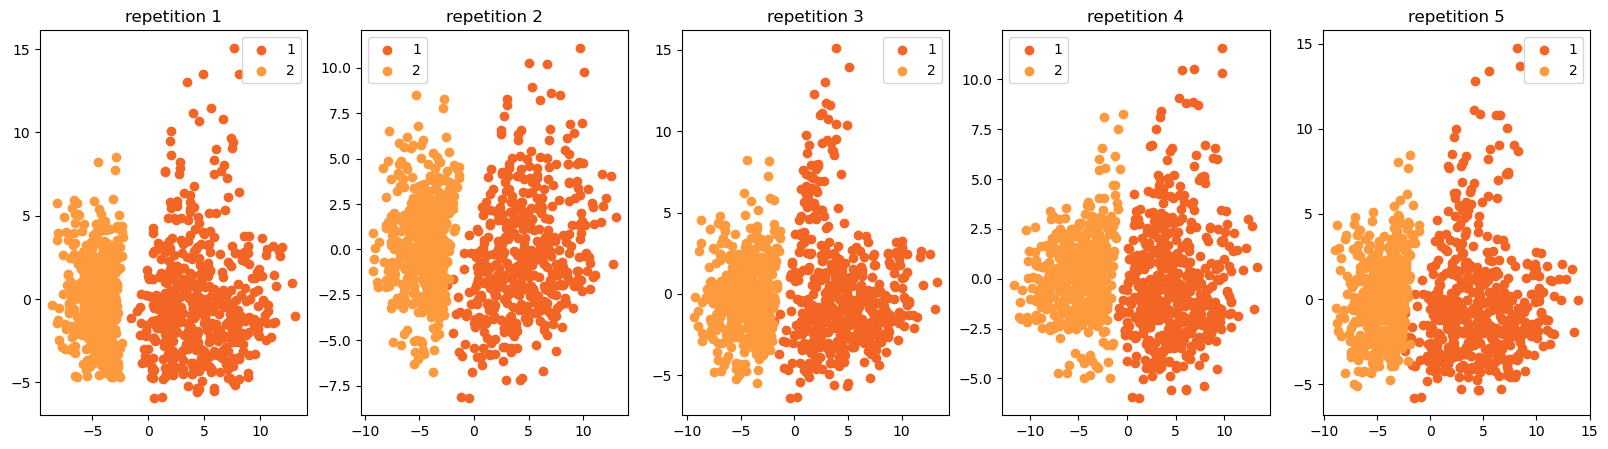

In [35]:
plot_scatters(res_cvae['s_latents'],data_csv_fn='../Data/synth-data-02.csv')

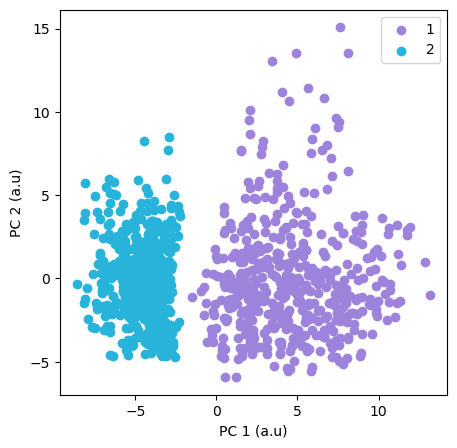

In [36]:
plot_scatter(res_cvae['s_latents'],data_csv_fn='../Data/synth-data-02.csv')

In [37]:
#plot_scatter(res_vae['latents'],data_csv_fn='../Data/synth-data-02.csv')

In [38]:
pretty_t_1sample(fisher_z(res_cvae['c_acc_ens']-res_cvae_N1000['c_acc_ens']),0)

t(4) = 5.78, p = 0.004


In [39]:

res_cvae_5type = get_cvae_res( ['CVAE-5type-dTkDjgdfxL','CVAE-5type-iAiIvvxnyA','CVAE-5type-HyABYkiDmv','CVAE-5type-uLtXBzUGUc','CVAE-5type-IFVZazjuWp'],data_csv_fn = '../synth-data-05/data_description.csv')


5


In [40]:
get_descriptive(res_cvae_5type['c_acc_indiv'])

M = 0.45, SD = 0.16, range 0.00-0.86


In [41]:
get_descriptive(res_cvae_5type['c_acc_ens'])

M = 0.59, SD = 0.04, range 0.53-0.65


In [42]:
pretty_t_1sample(res_cvae_5type['c_acc_ens'],1/5)

t(4) = 17.63, p < .001


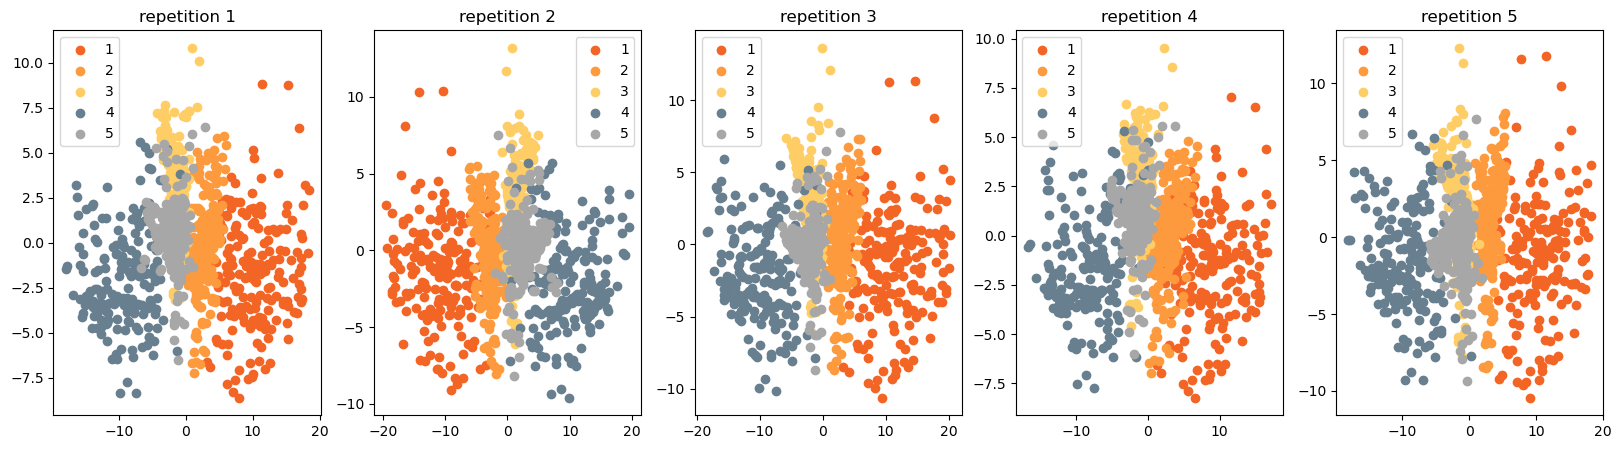

In [43]:
plot_scatters(res_cvae_5type['s_latents'],data_csv_fn='../synth-data-05/data_description.csv')

In [44]:

res_cvae_5typeN1000 = get_cvae_res(['CVAE-5type-N1000-zHXfpElhZf','CVAE-5type-N1000-bGwnoafftJ','CVAE-5type-N1000-gYdpyQdCzh','CVAE-5type-N1000-cleHmpYSXk','CVAE-5type-N1000-bCxBTltyKJ',],data_csv_fn = '../Data/synth-data-05-N1000.csv')


5


/data/aglinska/anaconda3/lib/python3.8/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/data/aglinska/anaconda3/lib/python3.8/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/data/aglinska/anaconda3/lib/python3.8/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,
/data/aglinska/anaconda3/lib/python3.8/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly

In [45]:
get_descriptive(res_cvae_5typeN1000['c_acc_indiv'])

M = 0.25, SD = 0.10, range 0.00-0.41


In [46]:
get_descriptive(res_cvae_5typeN1000['c_acc_ens'])

M = 0.27, SD = 0.02, range 0.24-0.29


In [47]:
pretty_t_1sample(res_cvae_5typeN1000['c_acc_ens'],1/5)

t(4) = 7.81, p = 0.001


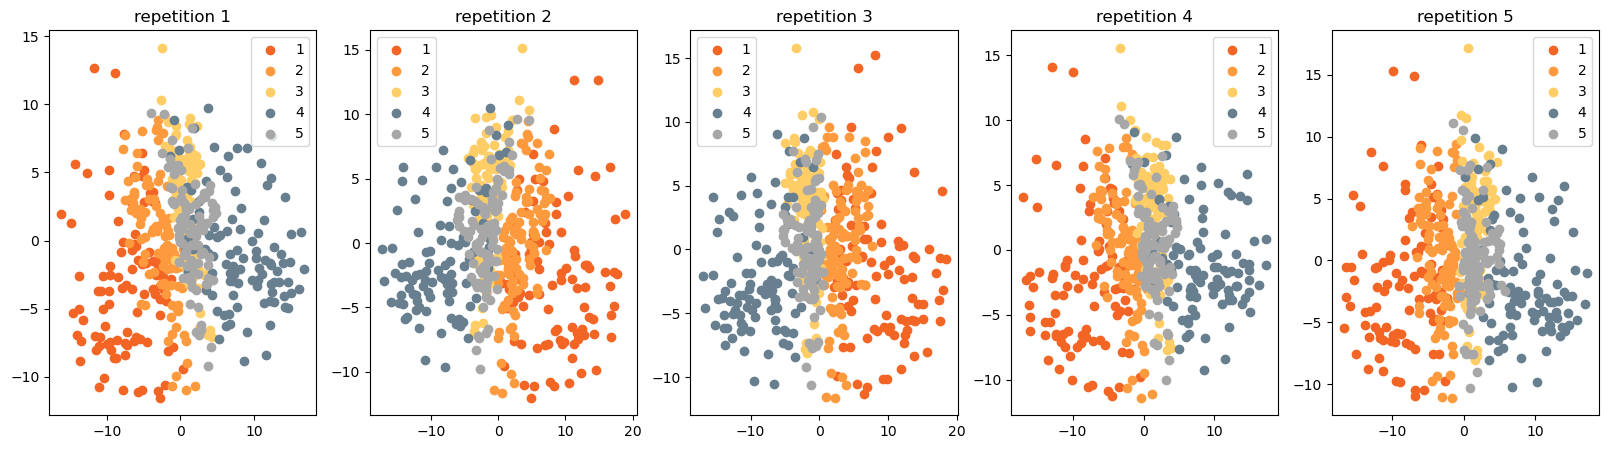

In [48]:
plot_scatters(res_cvae_5typeN1000['s_latents'],data_csv_fn='../Data/synth-data-05-N1000.csv')

In [49]:

#res_cvae_3typeN1000 = get_cvae_res(['CVAE-3type-N1000RpjbVewTkF','CVAE-3type-N1000COlRaiafwG','CVAE-3type-N1000rxbrpNgKNC','CVAE-3type-N1000cjDXIoxZHB','CVAE-3type-N1000YAjYFtDAep'],data_csv_fn = '../Data/synth-data-03-N1000.csv')
#res_cvae_3typeN1000 = get_cvae_res(['CVAE-3type-N1000HNNuPmQGry','CVAE-3type-N1000SVJIxTdsuB','CVAE-3type-N1000CVtphxTUCn','CVAE-3type-N1000eYIilgPIHN'],data_csv_fn = '../Data/synth-data-03-N1000.csv')
res_cvae_3typeN1000 = get_cvae_res(['CVAE-3type-RpjbVewTkF','CVAE-3type-COlRaiafwG','CVAE-3type-rxbrpNgKNC','CVAE-3type-cjDXIoxZHB','CVAE-3type-YAjYFtDAep'],data_csv_fn = '../synth-data-03/data_description.csv')


3


/data/aglinska/anaconda3/lib/python3.8/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,


In [50]:
res_cvae_3typeN1000['s_latents'].shape

(5, 20, 100, 1000, 2)

In [51]:
get_descriptive(res_cvae_3typeN1000['c_acc_indiv'])
get_descriptive(res_cvae_3typeN1000['c_acc_ens'])
pretty_t_1sample(res_cvae_3typeN1000['c_acc_ens'],1/3)

M = 0.71, SD = 0.17, range 0.00-0.97
M = 0.82, SD = 0.03, range 0.76-0.86
t(4) = 28.18, p < .001


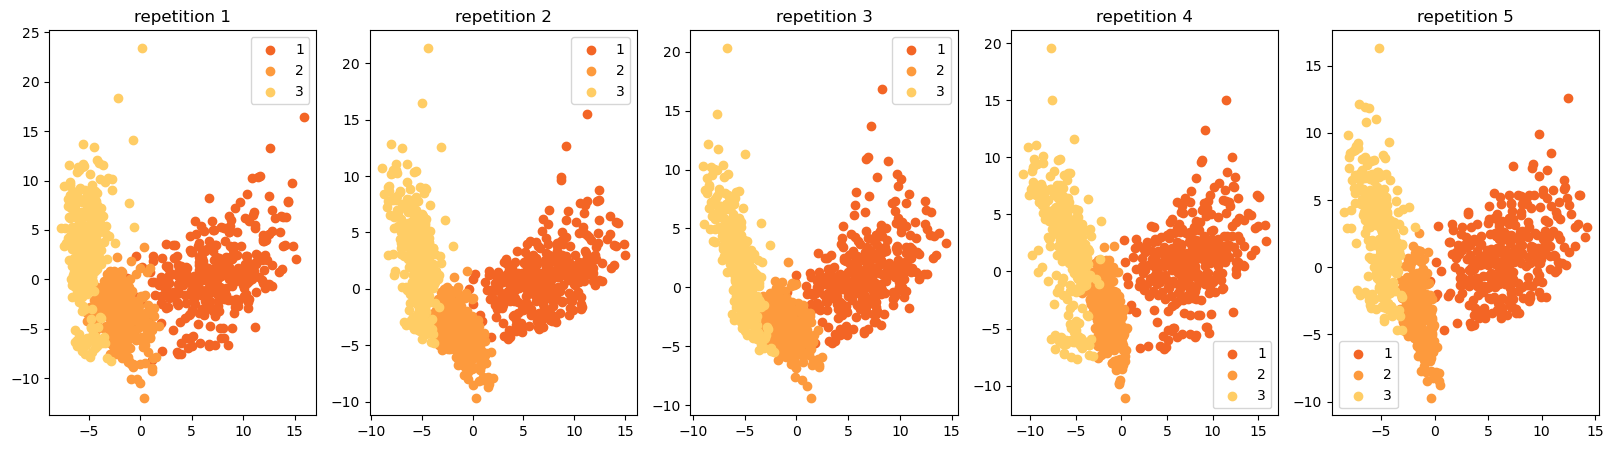

In [52]:
plot_scatters(res_cvae_3typeN1000['s_latents'],data_csv_fn='../synth-data-03/data_description.csv')

In [53]:

res_cvae_3type_N500 = get_cvae_res(['CVAE-3type-N500hmmrUxrGIt','CVAE-3type-N500pAJEYZHjYj','CVAE-3type-N500gYGEfcZxDC','CVAE-3type-N500OoREXdpler','CVAE-3type-N500XwLMaIGLLd'],data_csv_fn = '../Data/synth-data-03-N1000.csv')


3


/data/aglinska/anaconda3/lib/python3.8/site-packages/sklearn/mixture/_base.py:147: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  label = cluster.KMeans(n_clusters=self.n_components, n_init=1,


In [54]:
get_descriptive(res_cvae_3type_N500['c_acc_indiv'])
get_descriptive(res_cvae_3type_N500['c_acc_ens'])
pretty_t_1sample(res_cvae_3type_N500['c_acc_ens'],1/3)

M = 0.53, SD = 0.17, range 0.00-0.86
M = 0.60, SD = 0.04, range 0.55-0.67
t(4) = 13.14, p < .001


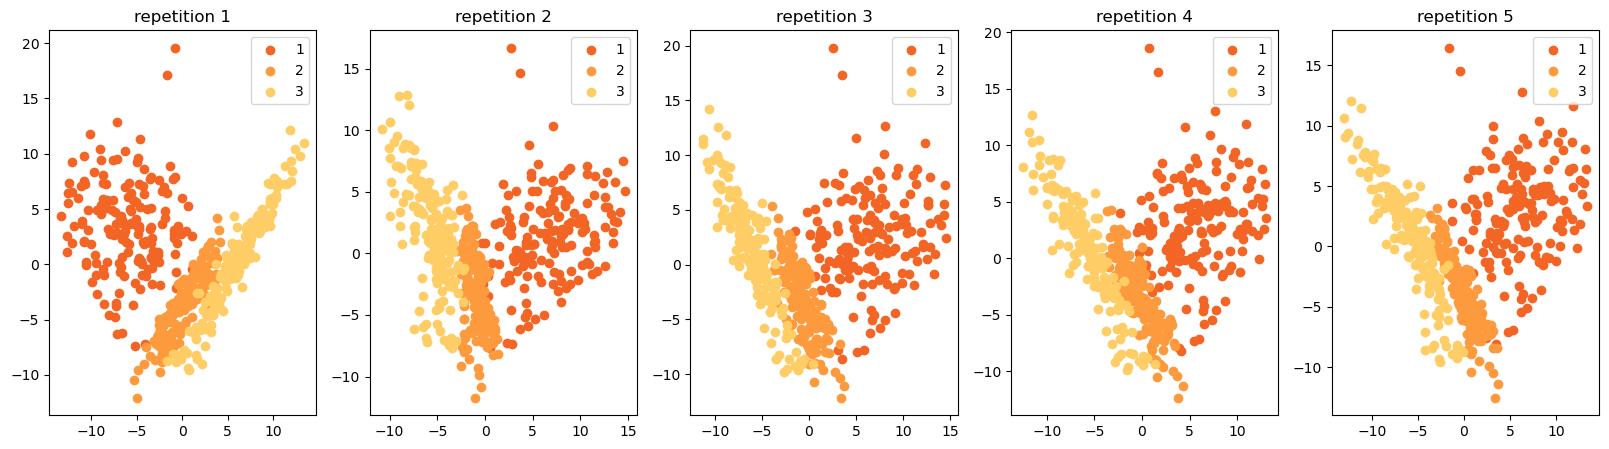

In [55]:
plot_scatters(res_cvae_3type_N500['s_latents'],data_csv_fn='../Data/synth-data-03-N1000.csv')

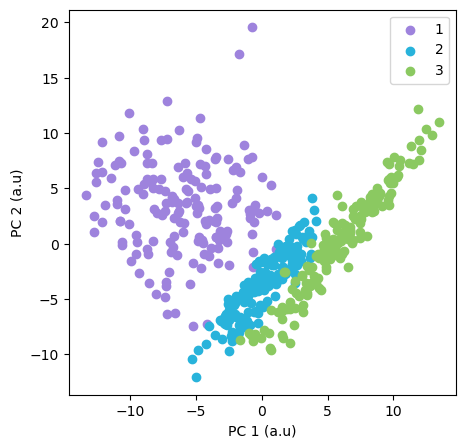

In [56]:
plot_scatter(res_cvae_3type_N500['s_latents'],data_csv_fn='../Data/synth-data-03-N1000.csv')

In [57]:
acc_cvae_2C_N1000 = res_cvae['c_acc_ens']
acc_cvae_2C_N500 = res_cvae_N1000['c_acc_ens']

acc_cvae_3C_N1000 = res_cvae_3typeN1000['c_acc_ens']
acc_cvae_3C_N500 = res_cvae_3type_N500['c_acc_ens']

acc_cvae_5C_N1000 = res_cvae_5type['c_acc_ens']
acc_cvae_5C_N500 = res_cvae_5typeN1000['c_acc_ens']

In [58]:
print('M1={:.2f},M2={:.2f},ΔM={:.2f}'.format(acc_cvae_2C_N500.mean(),acc_cvae_3C_N500.mean(),acc_cvae_2C_N500.mean()-acc_cvae_3C_N500.mean()))
print('M1={:.2f},M2={:.2f},ΔM={:.2f}'.format(acc_cvae_3C_N500.mean(),acc_cvae_5C_N500.mean(),acc_cvae_3C_N500.mean()-acc_cvae_5C_N500.mean()))

M1=0.90,M2=0.60,ΔM=0.31
M1=0.60,M2=0.27,ΔM=0.33


In [59]:
pretty_t_ind(fisher_z(acc_cvae_2C_N500),fisher_z(acc_cvae_3C_N500))
pretty_t_ind(fisher_z(acc_cvae_3C_N500),fisher_z(acc_cvae_5C_N500))

t(8) = 7.24, p < .001
t(8) = 12.27, p < .001


[0.9936336283509105, 0.8249751032440624, 0.5888510067307088]


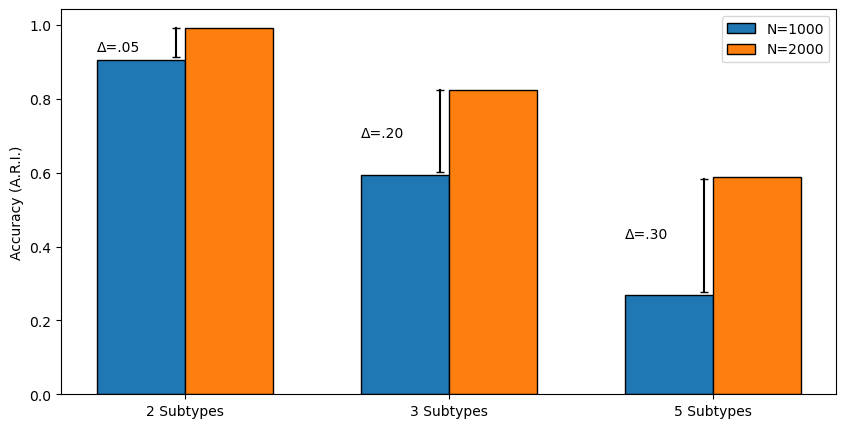

In [60]:
plt.figure(figsize=(10,5))
xs = [0,0.5, 1.5,2, 3,3.5]
#ys = [1,2,1,2,1,2]


# ys = [acc_cvae_2C_N500.mean(),
# acc_cvae_2C_N1000.mean(),
# acc_cvae_3C_N500.mean(),
# acc_cvae_3C_N1000.mean(),
# acc_cvae_5C_N500.mean(),
# acc_cvae_5C_N1000.mean()]
# plt.bar(xs,ys,edgecolor=[0,0,0],width=.5)

xs = [0, 1.5, 3,]
ys = [acc_cvae_2C_N500.mean(),
acc_cvae_3C_N500.mean(),
acc_cvae_5C_N500.mean(),]
plt.bar(xs,ys,edgecolor=[0,0,0],width=.5)

xs = [0.5, 2, 3.5]
ys = [acc_cvae_2C_N1000.mean(),
acc_cvae_3C_N1000.mean(),
acc_cvae_5C_N1000.mean(),]
plt.bar(xs,ys,edgecolor=[0,0,0],width=.5)

plt.legend(['N=1000','N=2000'])

plt.plot([3.2,3.2],[acc_cvae_5C_N500.mean()*1.03,acc_cvae_5C_N1000.mean()*.99],'k-_')

delta = acc_cvae_5C_N500.mean()*1.03-acc_cvae_5C_N1000.mean()*.99
plt.text(2.75,acc_cvae_5C_N500.mean()+abs(delta)/2,f'Δ={abs(delta):.2f}'.replace('0.','.'))

plt.plot([0.2,0.2],[acc_cvae_2C_N500.mean()*1.01,acc_cvae_2C_N1000.mean()*1.0],'k-_')
delta = acc_cvae_2C_N500.mean()*1.03-acc_cvae_2C_N1000.mean()*.99
plt.text(-.25,acc_cvae_2C_N500.mean()+abs(delta)/2,f'Δ={abs(delta):.2f}'.replace('0.','.'))

plt.plot([1.7,1.7],[acc_cvae_3C_N500.mean()*1.01,acc_cvae_3C_N1000.mean()*1.0],'k-_')
delta = acc_cvae_3C_N500.mean()*1.03-acc_cvae_3C_N1000.mean()*.99
plt.text(1.25,acc_cvae_3C_N500.mean()+abs(delta)/2,f'Δ={abs(delta):.2f}'.replace('0.','.'))


plt.xticks([.25,1.75,3.25],labels=['2 Subtypes','3 Subtypes','5 Subtypes'])
plt.ylabel('Accuracy (A.R.I.)')

print(ys)

In [61]:
# acc_cvae_2C_N1000 = res_cvae['c_acc_ens']
# acc_cvae_2C_N500 = res_cvae_N1000['c_acc_ens']

# acc_cvae_3C_N1000 = res_cvae_3typeN1000['c_acc_ens']
# acc_cvae_3C_N500 = res_cvae_3type_N500['c_acc_ens']

# acc_cvae_5C_N1000 = res_cvae_5type['c_acc_ens']
# acc_cvae_5C_N500 = res_cvae_5typeN1000['c_acc_ens']

#['varexps', 'varexps_m', 's_latents', 'z_latents', 'c_acc_indiv', 's_latents_stacked', 'c_acc_ens'])

In [62]:
df_2_N2000 = pd.read_csv('../Data/synth-data-02.csv')
df_2_N1000 = pd.read_csv('../Data/synth-data-02-N1000.csv')
df_3_N2000 = pd.read_csv('../synth-data-03/data_description.csv')
df_3_N1000 = pd.read_csv('../Data/synth-data-03-N1000.csv')
df_5_N1000 = pd.read_csv('../Data/synth-data-05-N1000.csv')
df_5_N2000 = pd.read_csv('../synth-data-05/data_description.csv')

df = df_3_N1000
arr = res_cvae_3typeN1000['s_latents_stacked']

def test_clustering_stability(arr,df,do_plot=False):
    arr = arr['s_latents_stacked'][0,:,:]
    patients = df['dx'].values==1
    controls = df['dx'].values==0
    subtype = df['subtype'].values[patients]
    isubtypes = np.unique(subtype)
    nsubtypes = len(isubtypes)

    # print(arr.shape)
    # print(df.shape)
    # print(subtype.shape)
    
    pc_comps = PCA(n_components=2).fit_transform(arr)
    if do_plot:
        plt.figure(figsize=(3,3))
        for i in isubtypes:
            plt.scatter(pc_comps[subtype==i,0],pc_comps[subtype==i,1],alpha=.5)
        plt.legend(isubtypes)
    caccs = []
    if do_plot:
        plt.figure(figsize=(15,5))
    for i in range(10):
        C = GaussianMixture(n_components=nsubtypes).fit_predict(arr)
        caccs.append( adjusted_rand_score(subtype,C) )
        if do_plot:
            plt.subplot(2,5,i+1)
            for i in np.unique(C):
                plt.scatter(pc_comps[C==i,0],pc_comps[C==i,1],alpha=.2)
                plt.title('ADI={:.2f}'.format(adjusted_rand_score(subtype,C)))
            #plt.tight_layout()
            plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.3)
    caccs = np.array(caccs)
    print(f'{nsubtypes} subtypes, N={df.shape[0]}: M={caccs.mean():.2f},SD={caccs.std():.2f},{caccs.min():.2f}-{caccs.max():.2f}')

dfs = [df_2_N2000,
       df_2_N1000,
       df_3_N2000,
       df_3_N1000,
       df_5_N2000,
       df_5_N1000,]

arrs = [res_cvae,
        res_cvae_N1000,
        res_cvae_3typeN1000,
        res_cvae_3type_N500,
        res_cvae_5type,
        res_cvae_5typeN1000,]

5 subtypes, N=1000: M=0.30,SD=0.02,0.26-0.34


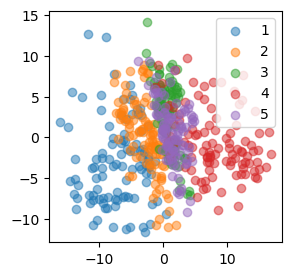

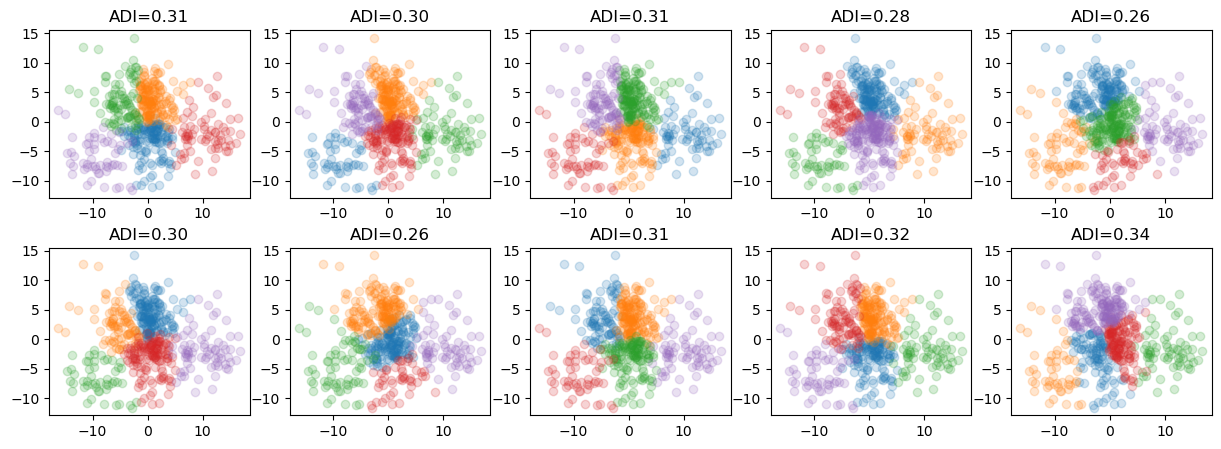

In [63]:
test_clustering_stability(arrs[5],dfs[5],do_plot=True)

5 subtypes, N=2000: M=0.62,SD=0.04,0.54-0.65


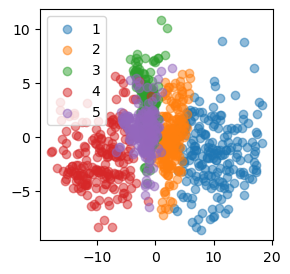

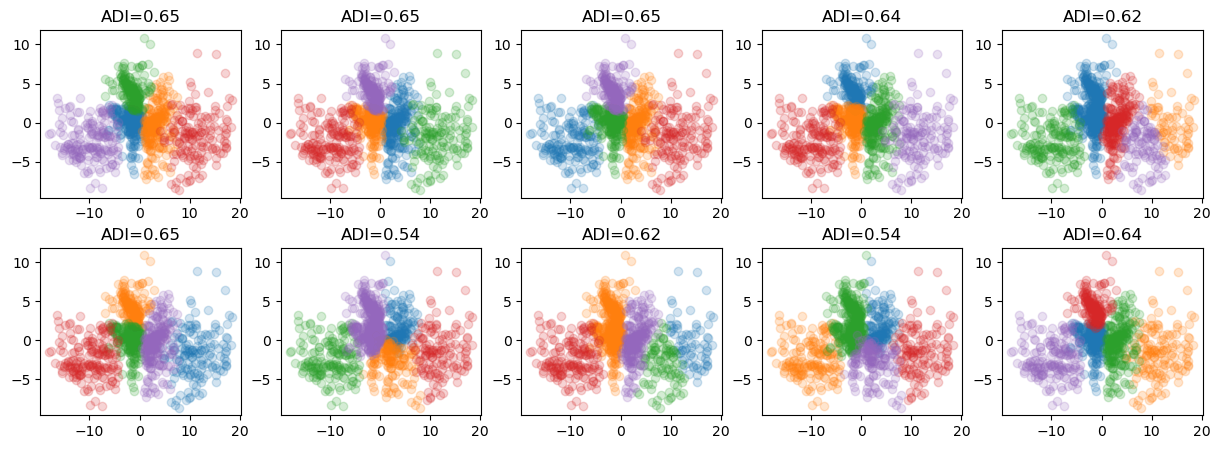

In [64]:
test_clustering_stability(arrs[4],dfs[4],do_plot=True)

In [65]:
for i in range(6):
    test_clustering_stability(arrs[i],dfs[i])

2 subtypes, N=2000: M=1.00,SD=0.00,1.00-1.00
2 subtypes, N=1000: M=0.96,SD=0.00,0.95-0.96
3 subtypes, N=2000: M=0.84,SD=0.00,0.84-0.84
3 subtypes, N=1000: M=0.67,SD=0.00,0.67-0.67
5 subtypes, N=2000: M=0.62,SD=0.03,0.54-0.65
5 subtypes, N=1000: M=0.27,SD=0.02,0.25-0.30


In [66]:
def plot_brain(mat):
    #mat = mat-mat[0,0,0]
    #mat = (mat-mat.min()) / (mat.max()-mat.min())
    #mat = (mat-mat.mean()) / mat.std()
    #vmin = mat.min()*.25
    #vmax = mat.max()*.75
    mat = mat.astype(np.float32)
    vmin = 0-abs(mat.max())
    vmax = 0+abs(mat.max())
    #print((mat.min(),mat.max()))
    #print(mat[0,0,0])
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1);plt.imshow(np.rot90(mat[:,:,32]),cmap='bwr',vmin=vmin,vmax=vmax);plt.xticks([]);plt.yticks([]);plt.colorbar(shrink=.48)
    plt.subplot(1,3,2);plt.imshow(np.rot90(mat[:,32,:]),cmap='bwr',vmin=vmin,vmax=vmax);plt.xticks([]);plt.yticks([]);plt.colorbar(shrink=.48)
    plt.subplot(1,3,3);plt.imshow(np.rot90(mat[32,:,:]),cmap='bwr',vmin=vmin,vmax=vmax);plt.xticks([]);plt.yticks([]);plt.colorbar(shrink=.48)

In [67]:
def get_neurosubtypes(df,data,latent_features,diffs=None):
    import itertools
    #df = pd.read_csv('../Data/synth-data-02.csv')
    #print(df.shape)
    patients = df['dx'].values==1
    controls = df['dx'].values==0
    subtype = df.iloc[patients]['subtype'].values
    isubtypes = np.unique(subtype)
    nsubtypes = len(isubtypes)
    nsubtypes
    
    #data = np.load('../Data/synth-data-02.npy').astype(np.float16)
    #print(data.shape)
    
    #latent_features = res_vae['latents_stacked']
    
    gt_diffs = data[patients,:,:,:]-data[controls,:,:,:]
    gt_subtypes = np.array([gt_diffs[subtype==isubtype,:,:,:].mean(axis=0).astype(np.float32) for isubtype in isubtypes])
    
    res = {}
    res['C'] = []
    res['gt_subtypes'] = gt_subtypes.astype(np.float32)
    res['data_subtypes'] = []
    res['corr_vec'] = []
    res['corr_vec_optimal'] = []
    res['data_subtypes_sorted'] = []
    
    def get_perm_corr(perm1,perm2,gt_subtypes,data_subtypes):
        #corrs = np.array([np.corrcoef(gt_subtypes[perm1[i],:,:,:].flatten(),data_subtypes[perm2[i],:,:,:].flatten())[0,1] for i in range(len(perm1))])

        corrs = []
        for i in range(len(perm1)):
            vec1 = gt_subtypes[perm1[i],:,:,:].flatten()
            vec2 = data_subtypes[perm2[i],:,:,:].flatten()
            #idx = np.vstack((vec1,vec2)).sum(axis=0)!=0
            idx = vec1!=0
            corr = np.corrcoef(vec1[idx],vec2[idx])[0,1]
            corrs.append(corr)
        corrs = np.array(corrs)

        
        corr_avg = corrs.mean()
        return corr_avg,corrs
    
    for rep in tqdm(np.arange(5)):
        C = GaussianMixture(n_components=nsubtypes).fit_predict(latent_features[rep,:,:])

        if type(diffs)==type(None): # If VAE data
            data_subtypes = np.array([data[patients,:,:,:].mean(axis=0)-data[patients,:,:,:][C==i,:,:,:].mean(axis=0) for i in np.unique(C)])
        else:
            data_subtypes = np.array([diffs[C==i,:,:,:].mean(axis=0) for i in np.unique(C)])

        permutations = np.array(list(itertools.permutations(np.arange(nsubtypes))))
        perm1 = np.arange(nsubtypes)
        corr_vec = np.array([get_perm_corr(perm1,permutations[i,:],gt_subtypes,data_subtypes)[0] for i in range(len(permutations))])
        get_perm_corr(perm1,permutations[np.argmax(corr_vec),:],gt_subtypes,data_subtypes)
        data_subtypes_sorted = data_subtypes[permutations[np.argmax(corr_vec),:],:,:,:]
        
        res['C'].append( C )
        res['data_subtypes'].append( data_subtypes.astype(np.float32) )
        res['corr_vec'].append( corr_vec )
        res['corr_vec_optimal'].append( get_perm_corr(perm1,permutations[np.argmax(corr_vec),:],gt_subtypes,data_subtypes) )
        res['data_subtypes_sorted'].append( data_subtypes_sorted.astype(np.float32) )
    print(res.keys())
    return res

In [68]:
df = pd.read_csv('../Data/synth-data-02-N1000.csv')
data = np.load('../Data/synth-data-02-N1000.npy').astype(np.float16)
latent_features = res_vae['latents_stacked']

print(df.shape)
print(data.shape)
print(latent_features.shape)

(1000, 12)
(1000, 64, 64, 64)
(5, 500, 80)


In [69]:
neurosubtypes_vae = get_neurosubtypes(df,data,latent_features,diffs=None)

100%|█████████████████████████████████████████████| 5/5 [00:11<00:00,  2.39s/it]

dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


In [70]:
np.array([val[0] for val in neurosubtypes_vae['corr_vec_optimal']]).mean().round(2)

0.41

In [71]:
np.array([val[1] for val in neurosubtypes_vae['corr_vec_optimal']]).mean(axis=0).round(2)

array([0.42, 0.4 ])

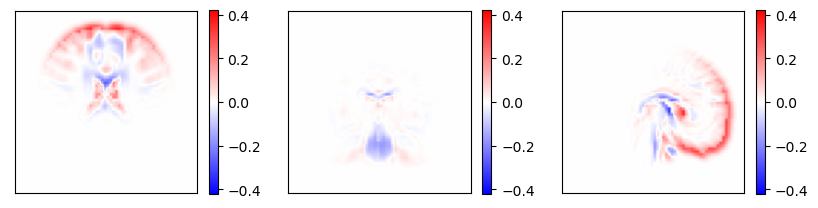

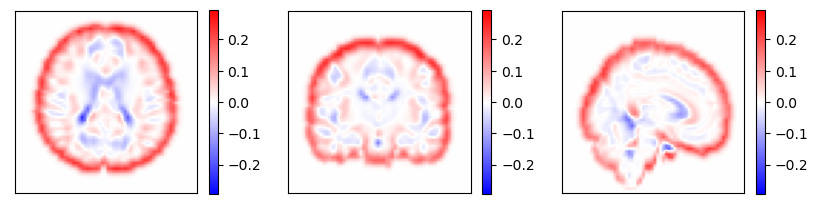

<Figure size 640x480 with 0 Axes>

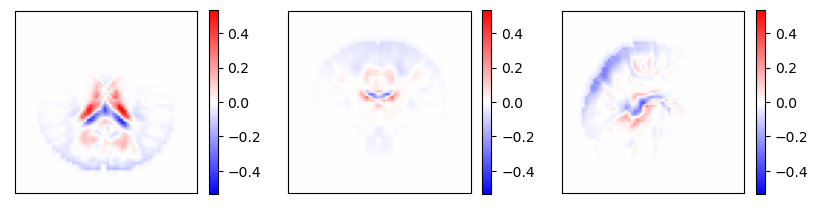

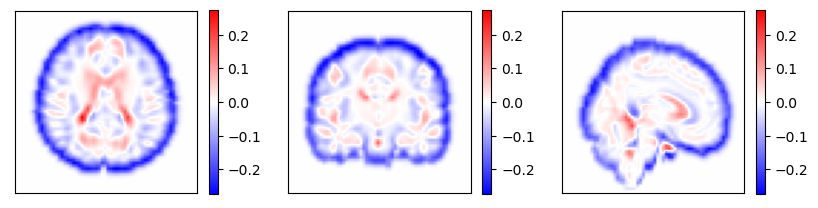

<Figure size 640x480 with 0 Axes>

In [72]:
for i in range(2):
    plot_brain(neurosubtypes_vae['gt_subtypes'][i,:,:,:])
    plot_brain(neurosubtypes_vae['data_subtypes_sorted'][0][i,:,:,:])
    plt.figure()

In [73]:
df = pd.read_csv('../Data/synth-data-02-N1000.csv')
data = np.load('../Data/synth-data-02-N1000.npy').astype(np.float16)
diffs = np.load('../Data/CVAE_diffs_mean-02-N1000.npy').astype(np.float16)[0:500]
latent_features = res_cvae_N1000['s_latents_stacked']

print(df.shape)
print(data.shape)
print(diffs.shape)
print(latent_features.shape)

(1000, 12)
(1000, 64, 64, 64)
(500, 64, 64, 64)
(5, 500, 40)


In [74]:
res_cvae_N1000['s_latents_stacked'].shape

(5, 500, 40)

In [75]:
neurosubtypes_cvae_2 = get_neurosubtypes(df,data,latent_features,diffs)

100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]

dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


In [76]:
neurosubtypes_cvae_2['corr_vec_optimal'][0]

(0.8724749649467363, array([0.86633158, 0.87861835]))

In [77]:
print(np.array([val[0] for val in neurosubtypes_cvae_2['corr_vec_optimal']]).mean().round(2))
print(np.array([val[1] for val in neurosubtypes_cvae_2['corr_vec_optimal']]).mean(axis=0).round(2))

0.87
[0.87 0.87]


In [78]:
vec1 = np.array([val[0] for val in neurosubtypes_cvae_2['corr_vec_optimal']])
vec2 = np.array([val[0] for val in neurosubtypes_vae['corr_vec_optimal']])
print('{:.2f}'.format(vec1.mean()-vec2.mean()))
pretty_t_ind(fisher_z(vec1),fisher_z(vec2))

0.46
t(8) = 180.87, p < .001


In [79]:
vec1 = np.array([val[1] for val in neurosubtypes_cvae_2['corr_vec_optimal']])
vec2 = np.array([val[1] for val in neurosubtypes_vae['corr_vec_optimal']])
pretty_t_ind(fisher_z(vec1[:,0]),fisher_z(vec2[:,0]))
pretty_t_ind(fisher_z(vec1[:,1]),fisher_z(vec2[:,1]))

t(8) = 339.71, p < .001
t(8) = 88.59, p < .001


In [80]:
print('{:.3f},{:.3f}'.format((vec1[:,0]-vec2[:,0]).mean(),(vec1[:,0]-vec2[:,0]).std()))
print('{:.3f},{:.3f}'.format((vec1[:,1]-vec2[:,1]).mean(),(vec1[:,1]-vec2[:,1]).std()))

0.448,0.004
0.472,0.005


In [81]:
print((vec1[:,0]-vec2[:,0]).mean()/(vec1[:,0]-vec2[:,0]).std())
print((vec1[:,1]-vec2[:,1]).mean()/(vec1[:,1]-vec2[:,1]).std())

106.19326887427589
89.84361042064121


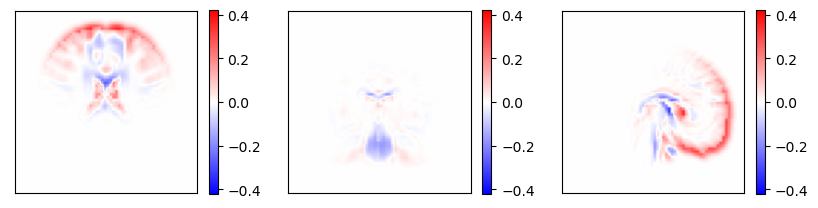

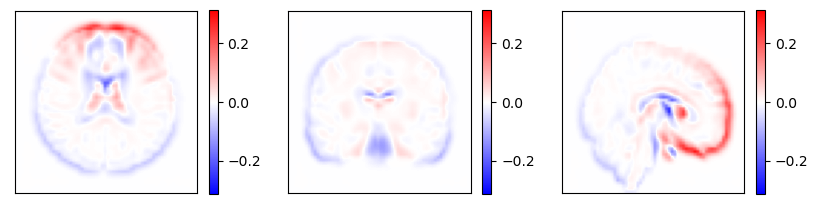

<Figure size 640x480 with 0 Axes>

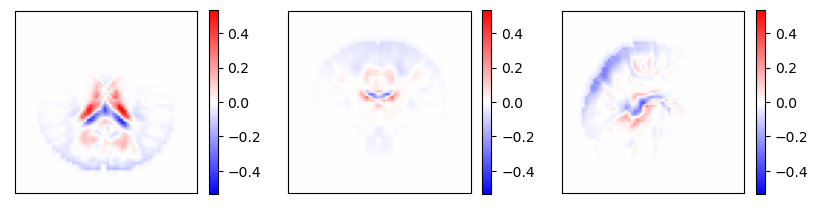

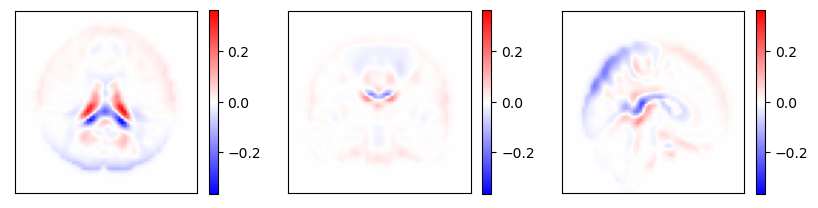

<Figure size 640x480 with 0 Axes>

In [82]:
for i in range(2):
    plot_brain(neurosubtypes_cvae_2['gt_subtypes'][i,:,:,:])
    plot_brain(neurosubtypes_cvae_2['data_subtypes_sorted'][0][i,:,:,:])
    plt.figure()

In [83]:
df = pd.read_csv('../Data/synth-data-02.csv')
data = np.load('../Data/synth-data-02.npy').astype(np.float16)
diffs = np.load('../Data/CVAE_diffs_mean-02-N2000.npy').astype(np.float16)
latent_features = res_cvae['s_latents_stacked']

print(df.shape)
print(data.shape)
print(diffs.shape)
print(latent_features.shape)

(2000, 11)
(2000, 64, 64, 64)
(1000, 64, 64, 64)
(5, 1000, 40)


In [84]:
neurosubtypes_cvae_2_N2000 = get_neurosubtypes(df,data,latent_features,diffs)

100%|█████████████████████████████████████████████| 5/5 [00:10<00:00,  2.20s/it]

dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


In [85]:
neurosubtypes_cvae_2_N2000['corr_vec_optimal'][0]

(0.9315725815509711, array([0.92022695, 0.94291821]))

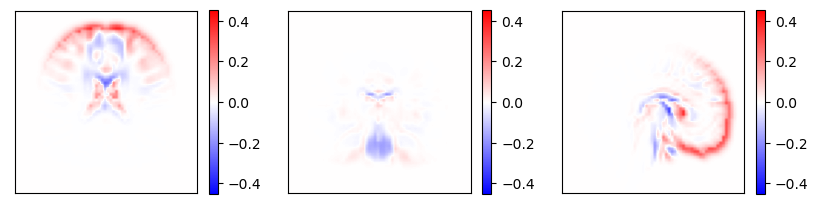

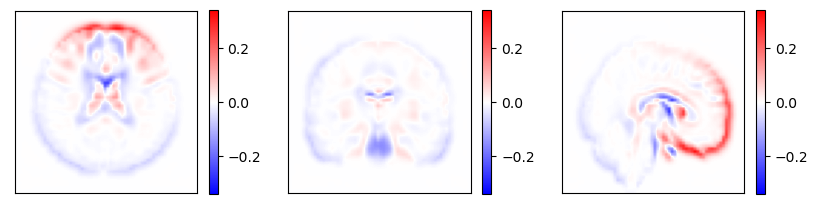

<Figure size 640x480 with 0 Axes>

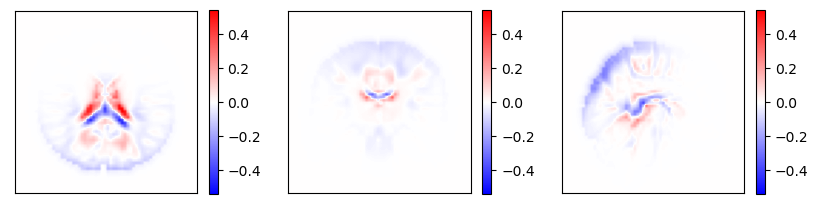

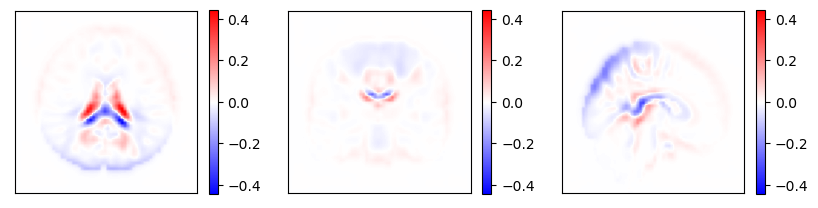

<Figure size 640x480 with 0 Axes>

In [86]:
for i in range(2):
    plot_brain(neurosubtypes_cvae_2_N2000['gt_subtypes'][i,:,:,:])
    plot_brain(neurosubtypes_cvae_2_N2000['data_subtypes_sorted'][0][i,:,:,:])
    plt.figure()

In [87]:
df = pd.read_csv('../Data/synth-data-03-N1000.csv')
data = np.load('../Data/synth-data-03-N1000.npy').astype(np.float16)
diffs = np.load('../Data/CVAE_diffs_mean-03.npy').astype(np.float16)[0:500]
latent_features = res_cvae_3type_N500['s_latents_stacked']

print(df.shape)
print(data.shape)
print(latent_features.shape)

(1000, 14)
(1000, 64, 64, 64)
(5, 500, 40)


In [88]:
neurosubtypes_cvae_3_N500 = get_neurosubtypes(df,data,latent_features,diffs)

100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.15s/it]

dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


In [89]:
neurosubtypes_cvae_3_N500['corr_vec_optimal'][0]

(0.9289911538181643, array([0.9057059 , 0.91397774, 0.96728982]))

In [90]:
vec1 = np.array([val[0] for val in neurosubtypes_cvae_2['corr_vec_optimal']])
vec2 = np.array([val[0] for val in neurosubtypes_cvae_3_N500['corr_vec_optimal']])

In [91]:
print('M1={:.3f},M2={:.3f},ΔM={:.3f}'.format(vec1.mean(),vec2.mean(),vec1.mean()-vec2.mean()))

M1=0.869,M2=0.927,ΔM=-0.059


In [92]:
pretty_t_ind(fisher_z(vec1),fisher_z(vec2))

t(8) = -51.71, p < .001


In [93]:
df = pd.read_csv('../synth-data-03/data_description.csv')
data = np.load('../synth-data-03/data.npy').astype(np.float16)
diffs = np.load('../Data/CVAE_diffs_mean-03.npy').astype(np.float16)
latent_features = res_cvae_3typeN1000['s_latents_stacked']

print(df.shape)
print(data.shape)
print(latent_features.shape)

(2000, 13)
(2000, 64, 64, 64)
(5, 1000, 40)


In [94]:
neurosubtypes_cvae_3_N1000 = get_neurosubtypes(df,data,latent_features,diffs)

100%|█████████████████████████████████████████████| 5/5 [00:11<00:00,  2.21s/it]

dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


In [95]:
neurosubtypes_cvae_3_N1000['corr_vec_optimal'][0]

(0.9319428161437622, array([0.89749792, 0.93033   , 0.96800053]))

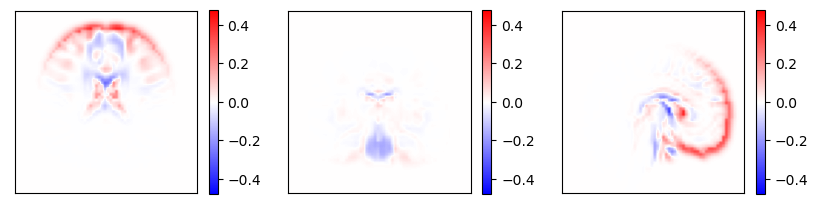

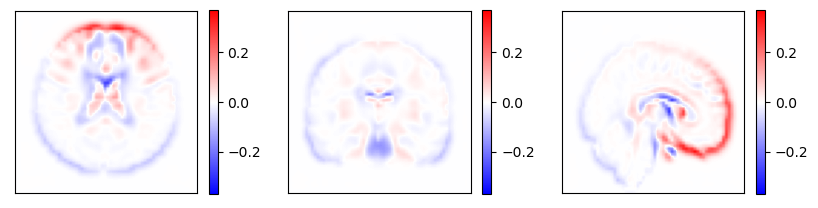

<Figure size 640x480 with 0 Axes>

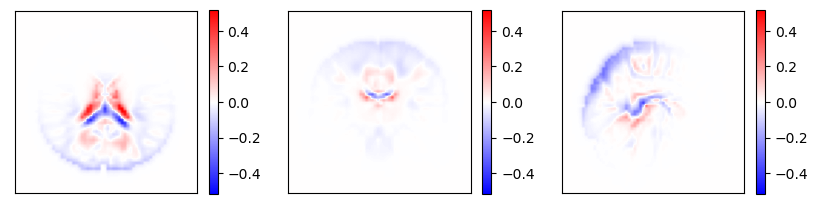

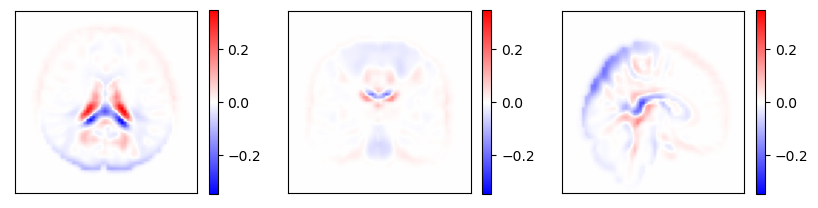

<Figure size 640x480 with 0 Axes>

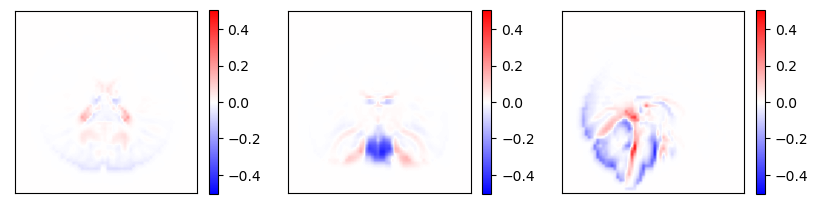

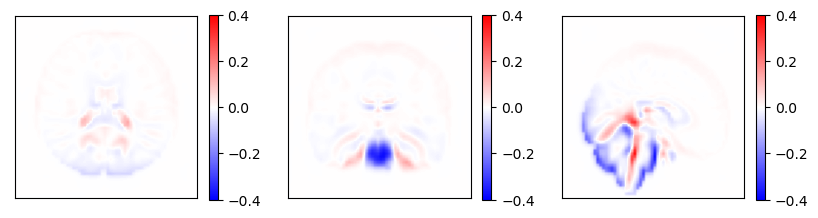

<Figure size 640x480 with 0 Axes>

In [96]:
for i in range(3):
    plot_brain(neurosubtypes_cvae_3_N1000['gt_subtypes'][i,:,:,:])
    plot_brain(neurosubtypes_cvae_3_N1000['data_subtypes_sorted'][0][i,:,:,:])
    plt.figure()

In [97]:
# df_2_N2000 = pd.read_csv('../Data/synth-data-02.csv')
# df_2_N1000 = pd.read_csv('../Data/synth-data-02-N1000.csv')
# df_3_N2000 = pd.read_csv('../synth-data-03/data_description.csv')
# df_3_N1000 = pd.read_csv('../Data/synth-data-03-N1000.csv')
# df_5_N1000 = pd.read_csv('../Data/synth-data-05-N1000.csv')
# df_5_N2000 = pd.read_csv('../synth-data-05/data_description.csv')

In [98]:
df = pd.read_csv('../Data/synth-data-05-N1000.csv')
data = np.load('../Data/synth-data-05-N1000.npy').astype(np.float16)
diffs = np.load('../Data/CVAE_diffs_mean-05.npy').astype(np.float16)[0:500]
latent_features = res_cvae_5typeN1000['s_latents_stacked']

print(df.shape)
print(data.shape)
print(latent_features.shape)

(1000, 14)
(1000, 64, 64, 64)
(5, 500, 40)


In [99]:
neurosubtypes_cvae_5_N500 = get_neurosubtypes(df,data,latent_features,diffs)

100%|█████████████████████████████████████████████| 5/5 [00:12<00:00,  2.51s/it]

dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


In [100]:
r_m = [] 
r_indiv = []
for i in range(10):
    neurosubtypes_cvae_5_N500 = get_neurosubtypes(df,data,latent_features,diffs)
    r_m.append(neurosubtypes_cvae_5_N500['corr_vec_optimal'][0][0] )
    r_indiv.append( neurosubtypes_cvae_5_N500['corr_vec_optimal'][0][1] )
r_m = np.array(r_m)
r_indiv = np.array(r_indiv)

100%|█████████████████████████████████████████████| 5/5 [00:12<00:00,  2.50s/it]


dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


100%|█████████████████████████████████████████████| 5/5 [00:14<00:00,  2.80s/it]


dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


100%|█████████████████████████████████████████████| 5/5 [00:13<00:00,  2.76s/it]


dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


100%|█████████████████████████████████████████████| 5/5 [00:13<00:00,  2.77s/it]


dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


100%|█████████████████████████████████████████████| 5/5 [00:13<00:00,  2.78s/it]


dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


100%|█████████████████████████████████████████████| 5/5 [00:13<00:00,  2.71s/it]


dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


100%|█████████████████████████████████████████████| 5/5 [00:13<00:00,  2.78s/it]


dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


100%|█████████████████████████████████████████████| 5/5 [00:13<00:00,  2.75s/it]


dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


100%|█████████████████████████████████████████████| 5/5 [00:13<00:00,  2.76s/it]


dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


100%|█████████████████████████████████████████████| 5/5 [00:14<00:00,  2.80s/it]

dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


In [101]:
print(r_indiv.min(axis=0))
print(r_indiv.max(axis=0))
print(r_indiv.std(axis=0))

[0.91308554 0.63285301 0.68972429 0.83296258 0.43698901]
[0.91741203 0.79576059 0.836359   0.83686291 0.60499321]
[0.00135446 0.04636807 0.04136422 0.00110513 0.0562267 ]


In [102]:
# for i in range(5):
#     plot_brain(neurosubtypes_cvae_5_N500['gt_subtypes'][i,:,:,:])
#     plot_brain(neurosubtypes_cvae_5_N500['data_subtypes_sorted'][0][i,:,:,:])
#     plt.figure()

In [103]:
df = pd.read_csv('../synth-data-05/data_description.csv')
data = np.load('../synth-data-05/data.npy').astype(np.float16)
diffs = np.load('../Data/CVAE_diffs_mean-05.npy').astype(np.float16)
latent_features = res_cvae_5type['s_latents_stacked']

print(df.shape)
print(data.shape)
print(latent_features.shape)

(2000, 13)
(2000, 64, 64, 64)
(5, 1000, 40)


In [104]:
neurosubtypes_cvae_5_N1000 = get_neurosubtypes(df,data,latent_features,diffs)

100%|█████████████████████████████████████████████| 5/5 [00:19<00:00,  3.96s/it]

dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


In [105]:
neurosubtypes_cvae_5_N1000['corr_vec_optimal'][0]

(0.7241904773730997,
 array([0.91765705, 0.87751628, 0.81174039, 0.83382617, 0.1802125 ]))

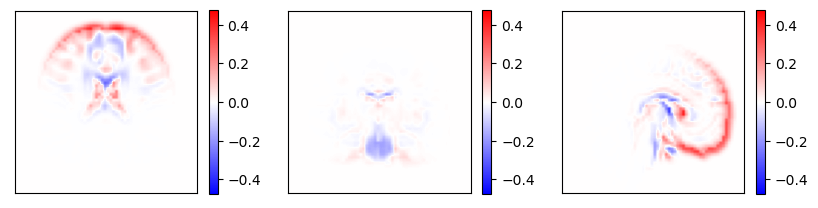

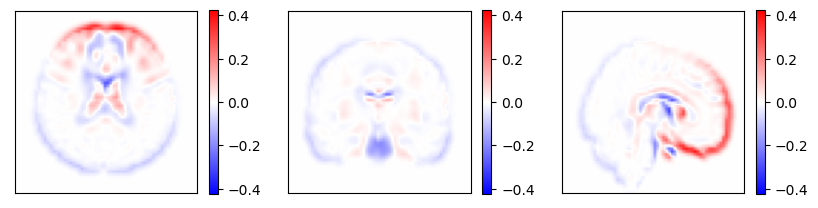

<Figure size 640x480 with 0 Axes>

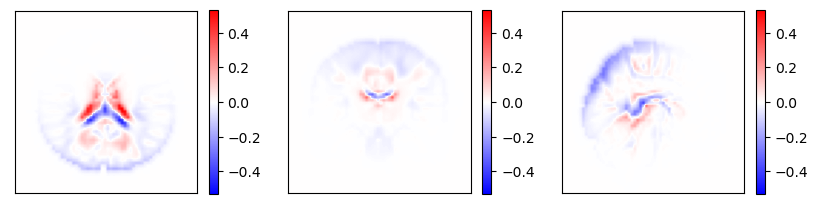

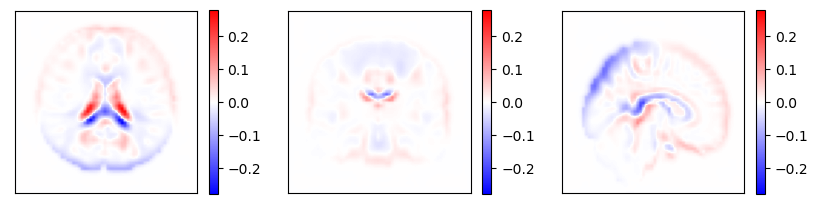

<Figure size 640x480 with 0 Axes>

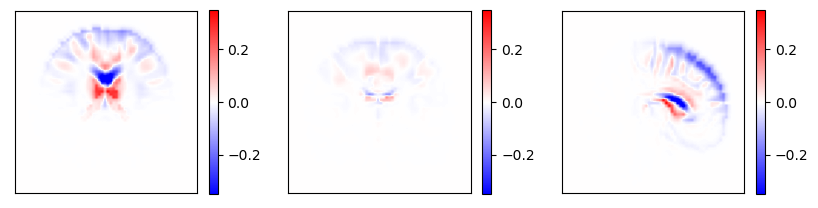

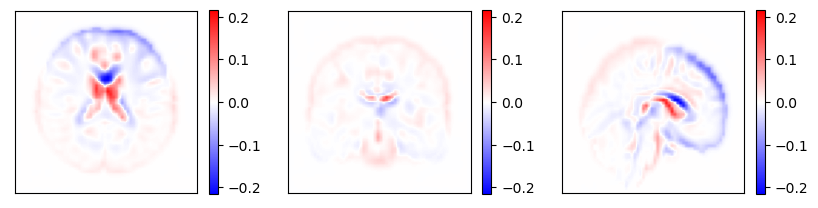

<Figure size 640x480 with 0 Axes>

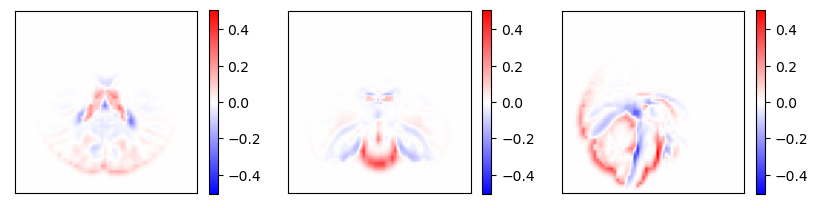

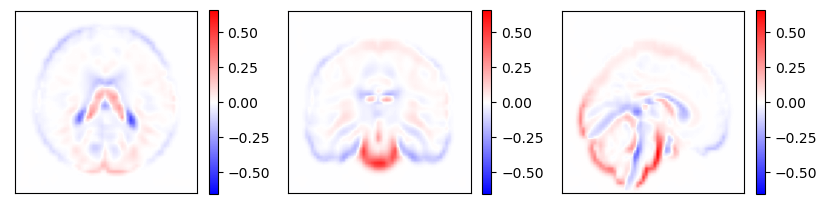

<Figure size 640x480 with 0 Axes>

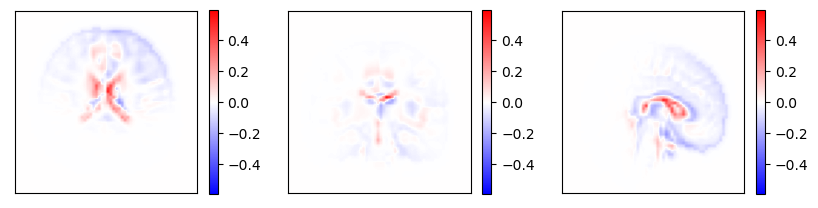

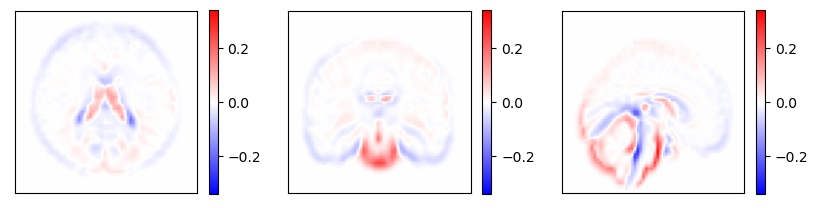

<Figure size 640x480 with 0 Axes>

In [106]:
for i in range(5):
    plot_brain(neurosubtypes_cvae_5_N1000['gt_subtypes'][i,:,:,:])
    plot_brain(neurosubtypes_cvae_5_N1000['data_subtypes_sorted'][0][i,:,:,:])
    plt.figure()

In [107]:
r_m = [] 
r_indiv = []
for i in range(10):
    neurosubtypes_cvae_5_N1000 = get_neurosubtypes(df,data,latent_features,diffs)
    r_m.append(neurosubtypes_cvae_5_N1000['corr_vec_optimal'][0][0] )
    r_indiv.append( neurosubtypes_cvae_5_N1000['corr_vec_optimal'][0][1] )
r_m = np.array(r_m)
r_indiv = np.array(r_indiv)

100%|█████████████████████████████████████████████| 5/5 [00:19<00:00,  3.90s/it]


dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


100%|█████████████████████████████████████████████| 5/5 [00:19<00:00,  3.89s/it]


dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


100%|█████████████████████████████████████████████| 5/5 [00:19<00:00,  3.93s/it]


dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


100%|█████████████████████████████████████████████| 5/5 [00:19<00:00,  3.87s/it]


dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


100%|█████████████████████████████████████████████| 5/5 [00:19<00:00,  3.95s/it]


dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


100%|█████████████████████████████████████████████| 5/5 [00:19<00:00,  3.97s/it]


dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


100%|█████████████████████████████████████████████| 5/5 [00:19<00:00,  3.93s/it]


dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


100%|█████████████████████████████████████████████| 5/5 [00:20<00:00,  4.01s/it]


dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


100%|█████████████████████████████████████████████| 5/5 [00:19<00:00,  3.92s/it]


dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


100%|█████████████████████████████████████████████| 5/5 [00:19<00:00,  3.91s/it]

dict_keys(['C', 'gt_subtypes', 'data_subtypes', 'corr_vec', 'corr_vec_optimal', 'data_subtypes_sorted'])


In [108]:
r_m.mean()

0.7909645433152067

In [109]:
r_m.std()

0.09676436916948486

In [110]:
print(r_indiv.min(axis=0))
print(r_indiv.max(axis=0))
print(r_indiv.std(axis=0))

[ 0.91177162  0.85782072 -0.13805843  0.83742077 -0.11721981]
[0.91884347 0.88492077 0.89308057 0.84519308 0.80913737]
[0.00189897 0.00815148 0.30316469 0.0022677  0.36956263]


In [111]:
def get_c_acc_reliability(df_fn,latent_features):
    #df_fn = '../synth-data-05/data_description.csv'
    #latent_features = res_cvae_5type['s_latents_stacked'][0,:,:]
    temp = pd.read_csv(df_fn)
    subtype = temp['subtype'].values[temp['dx'].values==1]
    n_subtypes = len(np.unique(subtype))
    c_acc = np.array([adjusted_rand_score(subtype,GaussianMixture(n_components=n_subtypes).fit_predict(latent_features)) for _ in range(100)])
    return c_acc

In [112]:
acc_rel_5 = get_c_acc_reliability('../synth-data-05/data_description.csv',res_cvae_5type['s_latents_stacked'][0,:,:])

In [113]:
acc_rel_3 = get_c_acc_reliability('../synth-data-03/data_description.csv',res_cvae_3typeN1000['s_latents_stacked'][0,:,:])

In [114]:
acc_rel_5.mean()

0.617795032263404

In [115]:
acc_rel_5.std()

0.03912991573031874

In [116]:
acc_rel_3.std()

2.220446049250313e-16

In [117]:
df = pd.read_csv('../synth-data-05new/data_description.csv')
#df = pd.read_csv('../Data/synth-data-05-N1000.csv')
patients = df['dx'].values==1
controls = df['dx'].values==0
subtype = df['subtype'].values[patients]
isubtypes = np.unique(subtype)

In [118]:
#indir = '../scratch/CVAE-5type-new-SEOUWNcwrP/stage_2/'
#indir = '../scratch/CVAE-5type-N1000-zHXfpElhZf/stage_2/'
indir = '../scratch/CVAE-5type-new8-zzzygCizHs/stage_2/'

files = [f for f in os.listdir(indir) if f.startswith('training_log_')]
s_all = [np.load(os.path.join(indir,file))['s_patients'][-1,:,:] for file in files]
s_stacked = np.concatenate(s_all,axis=1)
s_all = np.array(s_all)
print(s_stacked.shape)
print(s_all.shape)

(1000, 160)
(20, 1000, 8)


In [119]:
pc_comps = PCA(n_components=2).fit_transform(s_stacked)

In [120]:
C = GaussianMixture(n_components=5).fit_predict(s_stacked)

In [121]:
adjusted_rand_score(C,subtype)

0.9800357156938722

In [122]:
# Right Temporal, Left Temporal, Frontal, Occipital, Dorsal

Text(0, 0.5, 'PC 2 (a.u)')

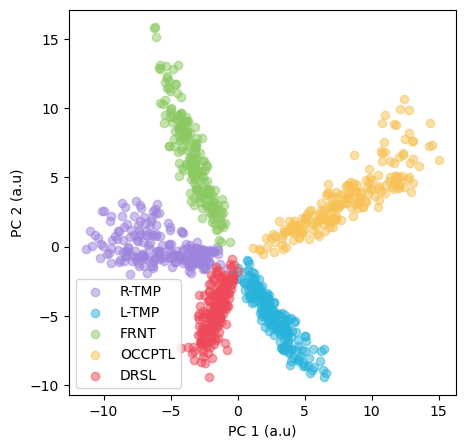

In [123]:
colors = [[158,131,221],[40,179,219],[139,201,97],[247,193,83],[237,73,89]]
plt.figure(figsize=(5,5))
r = 0
for i in range(5):
    plt.scatter(pc_comps[subtype==i+1,0],pc_comps[subtype==i+1,1],color=np.array(colors[i])/255,alpha=.5)
#plt.legend(np.unique(subtype))
plt.legend(['R-TMP','L-TMP','FRNT','OCCPTL','DRSL'])
plt.xlabel('PC 1 (a.u)')
plt.ylabel('PC 2 (a.u)')

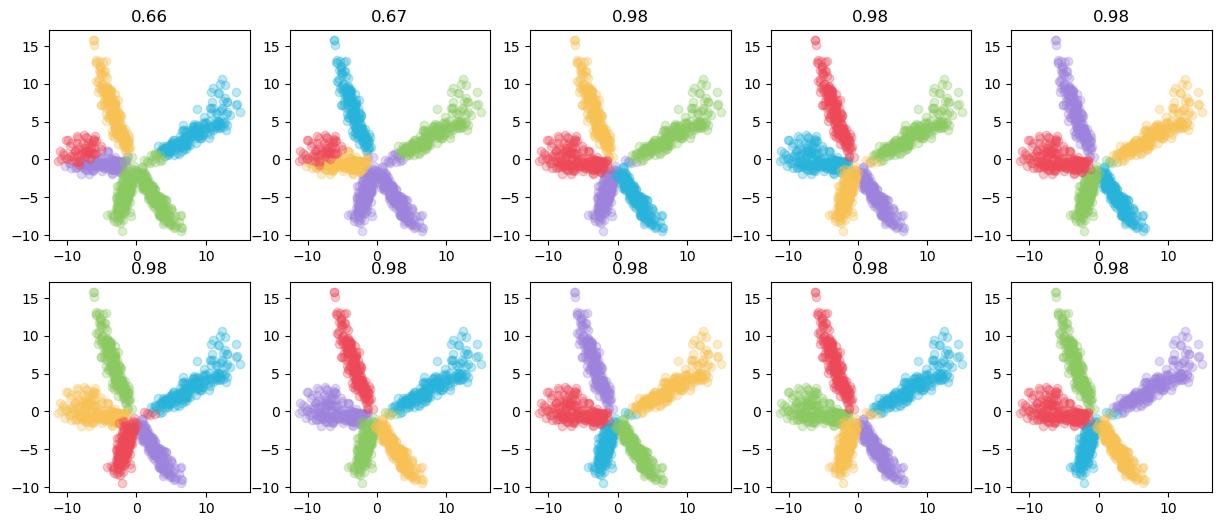

In [124]:
plt.figure(figsize=(15,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    C = GaussianMixture(n_components=5).fit_predict(s_stacked)
    colors = [[158,131,221],[40,179,219],[139,201,97],[247,193,83],[237,73,89]]
    #plt.figure(figsize=(5,5))
    r = 0
    for i in range(5):
        plt.scatter(pc_comps[C==i,0],pc_comps[C==i,1],color=np.array(colors[i])/255,alpha=.3)
    #plt.legend(np.unique(subtype))
    #plt.legend(['R-TMP','L-TMP','FRNT','OCCPTL','DRSL'])
    #plt.xlabel('PC 1 (a.u)')
    #plt.ylabel('PC 2 (a.u)')
    plt.title(adjusted_rand_score(C,subtype).round(2))

In [125]:
accs = np.array([adjusted_rand_score(subtype,GaussianMixture(n_components=5).fit_predict(s_stacked)) for _ in range(100)])

(array([ 1.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,  0., 96.]),
 array([0.55509938, 0.59759301, 0.64008664, 0.68258028, 0.72507391,
        0.76756755, 0.81006118, 0.85255481, 0.89504845, 0.93754208,
        0.98003572]),
 <BarContainer object of 10 artists>)

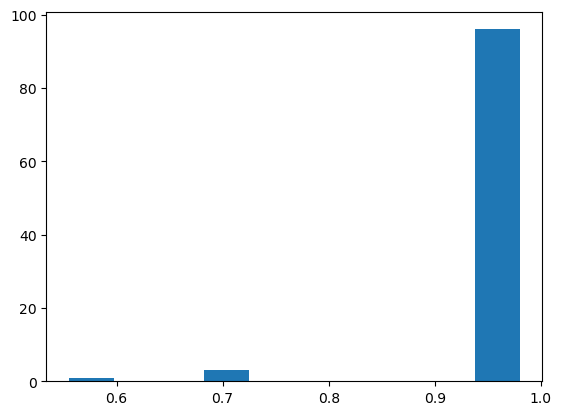

In [126]:
plt.hist(accs)

In [127]:
(accs.max(),accs.min())

(0.9800357156938722, 0.5550993765717863)

In [128]:
accs.std()

0.0632232055803845

In [129]:
accs.mean()

0.9673879768238798

In [130]:
#data = np.load('../synth-data-05new/data.npy')

In [131]:
# gt_diffs = data[patients,:,:,:]-data[controls,:,:,:]
# gt_subtypes = np.array([gt_diffs[subtype==isubtype,:,:,:].mean(axis=0).astype(np.float32) for isubtype in isubtypes])

In [132]:
for gt_subtype in gt_subtypes:
    plot_brain(gt_subtype)

NameError: name 'gt_subtypes' is not defined